In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Colab Notebooks/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/datasets
/content/drive/My Drive/Colab Notebooks/assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

多类支持向量机练习
填写并提交此已完成的工作表（包括其输出和工作表外的任何支持代码）以及您的作业提交。有关更多详细信息，请参阅课程网站上的作业页面。

在本练习中，您将：

为SVM实现一个完全矢量化的损失函数
实现其解析梯度的完全矢量化表达式
使用数值梯度检查您的实现
使用验证集来调整学习率和正则化强度
用SGD优化损失函数
可视化最终学习到的权重

In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


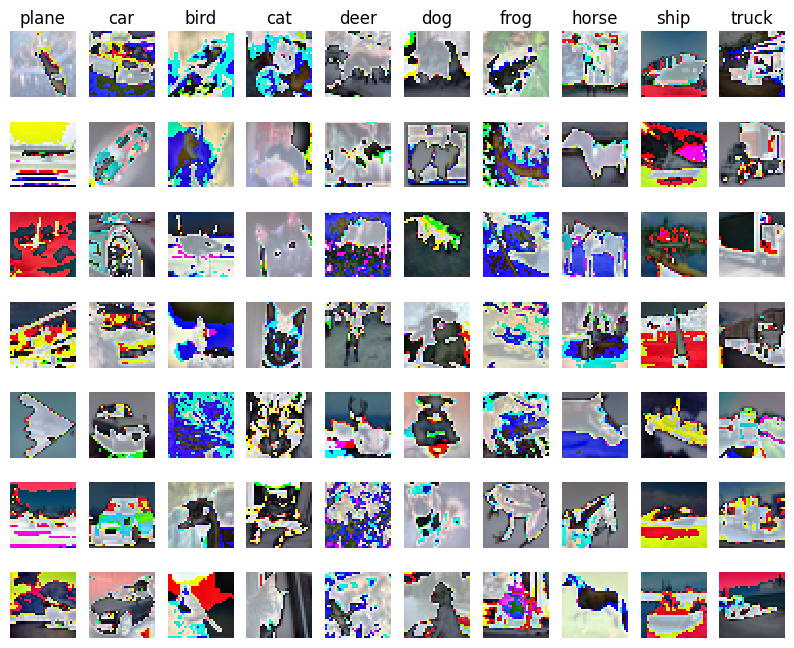

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[-0.06884204 -0.07440531 -0.07988163 -0.08466612 -0.09433918 -0.09955959
 -0.08988898 -0.10287429 -0.10507265 -0.08418653]


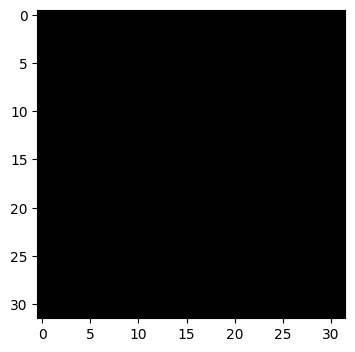

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`.

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.852909


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

从上面的函数返回的grad现在都是零。推导并实现SVM成本函数的梯度，并将其内联到函数SVM_loss_naive中。您会发现将新代码交织在现有函数中很有帮助。

为了检查您是否正确实现了梯度，您可以对损失函数的梯度进行数值估计，并将数值估计与您计算的梯度进行比较。我们为您提供了这样的代码：




In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -20.865802 analytic: -20.865802, relative error: 1.696903e-11
numerical: -35.465988 analytic: -35.465988, relative error: 2.785795e-12
numerical: -10.495604 analytic: -10.495604, relative error: 7.509013e-12
numerical: 25.302202 analytic: 25.302202, relative error: 6.715378e-12
numerical: 6.347095 analytic: 6.304398, relative error: 3.374894e-03
numerical: 15.050239 analytic: 15.014856, relative error: 1.176890e-03
numerical: 13.958923 analytic: 13.958923, relative error: 1.743757e-11
numerical: 19.344665 analytic: 19.313775, relative error: 7.990365e-04
numerical: 49.723402 analytic: 49.723402, relative error: 5.306628e-12
numerical: -3.882825 analytic: -3.882825, relative error: 3.180253e-11
numerical: -11.743259 analytic: -11.743259, relative error: 3.901606e-12
numerical: 4.929827 analytic: 4.929827, relative error: 4.826248e-11
numerical: 22.678560 analytic: 22.633927, relative error: 9.850038e-04
numerical: 13.062279 analytic: 13.126797, relative error: 2.463544e-03
nu

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  

**内联问题1**

渐变检查中的尺寸可能偶尔会不完全匹配。造成这种差异的原因是什么？这是令人担忧的原因吗？在一维中，梯度检查可能失败的一个简单例子是什么？如何改变这种情况发生频率的边际影响*提示：SVM损失函数严格来说是不可微的*

可以出现不可微点 从而导致数据出现离散  可能应该使用次梯度

In [12]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.852909e+00 computed in 0.145290s
Vectorized loss: 8.852909e+00 computed in 0.021044s
difference: -0.000000


In [13]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
#损失是一个单一的数字，因此很容易比较计算出的值
#通过这两种实现方式。另一方面，梯度是一个矩阵，因此
#我们使用Frobenius范数来比较它们。
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.145977s
Vectorized loss and gradient: computed in 0.009476s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

随机梯度下降法
我们现在有了损失的矢量化和高效表达式，梯度和我们的梯度与数值梯度相匹配。因此，我们准备进行SGD，以尽量减少损失。此部分的代码将编写在cs231n/classifiers/linear_classier.py中。

In [14]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 787.642052
iteration 100 / 1500: loss 287.619258
iteration 200 / 1500: loss 108.170214
iteration 300 / 1500: loss 42.775022
iteration 400 / 1500: loss 18.481808
iteration 500 / 1500: loss 9.936134
iteration 600 / 1500: loss 7.250079
iteration 700 / 1500: loss 5.428877
iteration 800 / 1500: loss 5.607115
iteration 900 / 1500: loss 5.064148
iteration 1000 / 1500: loss 5.352692
iteration 1100 / 1500: loss 5.180625
iteration 1200 / 1500: loss 5.016346
iteration 1300 / 1500: loss 5.128123
iteration 1400 / 1500: loss 5.264519
That took 5.817861s


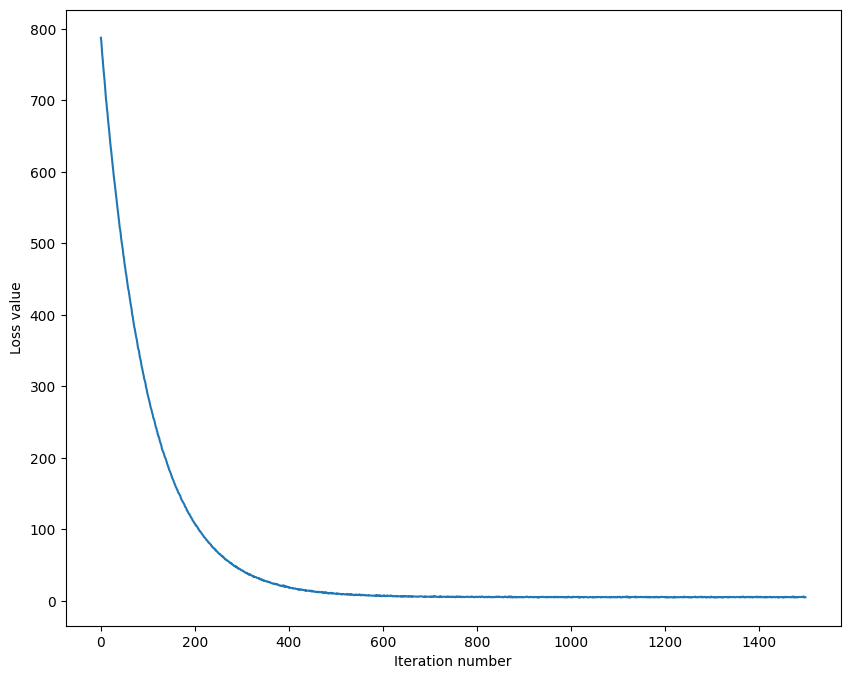

In [15]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [16]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.367694
validation accuracy: 0.387000


In [18]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
#使用验证集来调整超参数（正则化强度和
#学习率）。你应该尝试不同的学习范围
#速率和正则化强度；如果你小心，你应该能够
#在验证集上获得约0.39（>0.385）的分类准确率。

#注意：在超参数搜索过程中，您可能会看到运行时/溢出警告。
#这可能是由极端值引起的，而不是错误。

#结果是字典映射形式的元组
#（learning_rate，regularization_strength）转换为以下形式的元组
#（培训准确性、验证准确性）。精度只是分数
#正确分类的数据点。classifier.py。
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
#迄今为止，我们看到的最高验证准确率。
#实现最高验证率的LinearSVM对象。

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.
#待办事项：#
#编写通过调整验证来选择最佳超参数的代码#
#集。对于每个超参数组合，在#
#训练集，计算其在训练集和验证集上的准确性，以及#
#将这些数字存储在结果字典中。此外，储存最好的#
#best_val中的验证精度和实现这一点的LinearSVM对象#
#best_svm的准确性#
#                                                                              #
#提示：在开发过程中，您应该为num_iters使用一个较小的值#
#验证代码，这样SVM就不会花费太多时间进行训练；一旦你#
#确信您的验证代码有效，您应该重新运行验证#
#数值较大的代码。率。                   #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters作为参考提供。您可能想也可能不想更改这些超参数
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy>best_val:
          best_val=val_accuracy
          best_svm=svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 798.209971
iteration 100 / 1500: loss 291.043613
iteration 200 / 1500: loss 109.260513
iteration 300 / 1500: loss 42.812879
iteration 400 / 1500: loss 19.052563
iteration 500 / 1500: loss 10.148816
iteration 600 / 1500: loss 7.127727
iteration 700 / 1500: loss 5.768279
iteration 800 / 1500: loss 5.178510
iteration 900 / 1500: loss 5.363164
iteration 1000 / 1500: loss 5.029504
iteration 1100 / 1500: loss 5.096475
iteration 1200 / 1500: loss 5.376364
iteration 1300 / 1500: loss 5.326375
iteration 1400 / 1500: loss 5.267932
iteration 0 / 1500: loss 1556.617157
iteration 100 / 1500: loss 211.244402
iteration 200 / 1500: loss 33.320834
iteration 300 / 1500: loss 9.689047
iteration 400 / 1500: loss 6.959124
iteration 500 / 1500: loss 5.621722
iteration 600 / 1500: loss 5.304721
iteration 700 / 1500: loss 5.576459
iteration 800 / 1500: loss 5.337715
iteration 900 / 1500: loss 6.111979
iteration 1000 / 1500: loss 5.752152
iteration 1100 / 1500: loss 5.701576
iteration 

/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/classifiers/linear_svm.py:114: RuntimeWarning: overflow encountered in scalar multiply
  loss+=reg*np.sum(W * W)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/classifiers/linear_svm.py:114: RuntimeWarning: overflow encountered in multiply
  loss+=reg*np.sum(W * W)


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1571.865847
iteration 100 / 1500: loss 4341977363987416038815984985046988101540115379970160562708236190535340514260846013110783677259765465985997963471236064346112.000000
iteration 200 / 1500: loss 11212070518812621788789892431219329371927492442329469589389236232820306853975758298377572260282235121872643162384286183123722235851723028892405921870720015276062730394231753791005912232933259589473049865517489704614323981587955790203892491354112.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/classifiers/linear_svm.py:142: RuntimeWarning: overflow encountered in multiply
  dW+=2*reg*W


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.365510 val accuracy: 0.369000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.360633 val accuracy: 0.357000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.060551 val accuracy: 0.057000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.369000


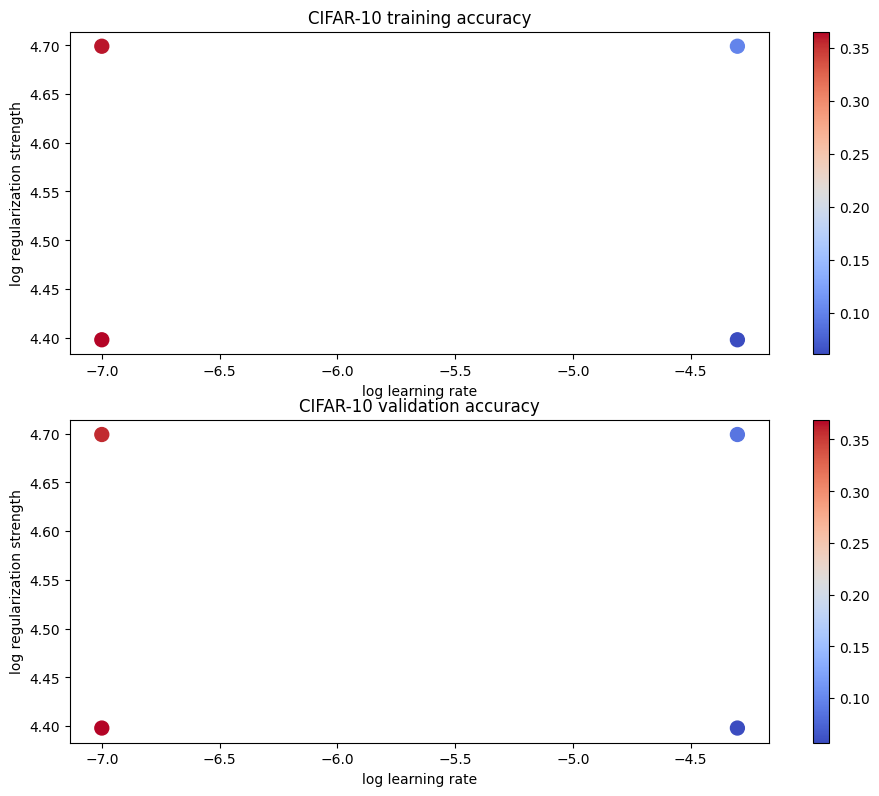

In [19]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [20]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.246000


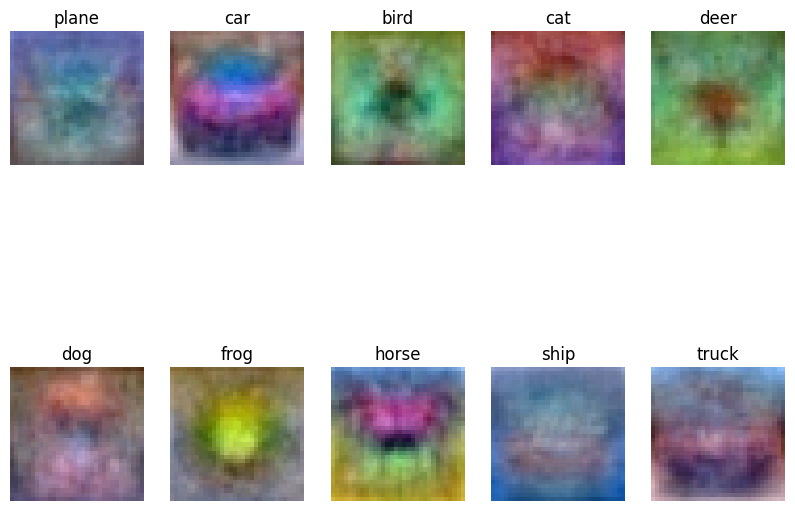

In [21]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

描述你的可视化SVM权重是什么样子的，并简要解释为什么它们看起来是这样的。
$\color{blue}{\textit Your Answer:}$ *fill this in*  

每个图片都比较模糊 勉强能看出其分类 因为他需要符合此类的大部分特征